## Inspect, Crop, and Export Remote Sensing Imagery

In [1]:
from PIL import Image
import os
import random
import argparse
import numpy as np
import json
import csv
import rasterio
import matplotlib
import folium
from pyproj import Proj, transform
import png

%matplotlib inline

Image.MAX_IMAGE_PIXELS = 100000000000
data_dir = '../data/'

In [18]:
# ingest the image
# TODO change this to a command line argument
# Bird Shoal
#infile = data_dir + "mosaics/180522BirdSEO_WGS84_transparent_mosaic_group1.tif"

# Carrot Island
#infile = data_dir + "mosaics/180605CarrotEO_transparent_mosaic_group1.tif"

# Middle Marsh
infile = data_dir + "mosaics/middlemarshrtk22feb2017_transparent_mosaic_group1.tif"

img_dir = '..' + infile.split(".")[2]
prj_name = img_dir.split("/")[-1]

In [19]:
img_dir

'../data/mosaics/middlemarshrtk22feb2017_transparent_mosaic_group1'

In [20]:
dataset = rasterio.open(infile)

In [21]:
# what is the name of this image
img_name = dataset.name
print('Image filename: {n}\n'.format(n=img_name))

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# Does the raster have a description or metadata?
desc = dataset.descriptions
metadata = dataset.meta

print('Raster description: {desc}\n'.format(desc=desc))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
print('Image projection:')
print(proj, '\n')

# What is the raster's "geo-transform"
gt = dataset.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

Image filename: ../data/mosaics/middlemarshrtk22feb2017_transparent_mosaic_group1.tif

Number of bands in image: 4

Image size is: 67238 rows x 117433 columns

Raster description: (None, None, None, None)

Raster driver: GTiff

Image projection:
+init=epsg:32618 

Image geo-transform:
| 0.02, 0.00, 351182.36|
| 0.00,-0.02, 3841076.55|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 117433, 'height': 67238, 'count': 4, 'crs': CRS({'init': 'epsg:32618'}), 'transform': Affine(0.024780000000000003, 0.0, 351182.36072000006,
       0.0, -0.024780000000000003, 3841076.5514900004)}




### plot the image and inspect bands

In [6]:
random.randint(1,60000)

30445

In [7]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window

import matplotlib.pyplot as plt

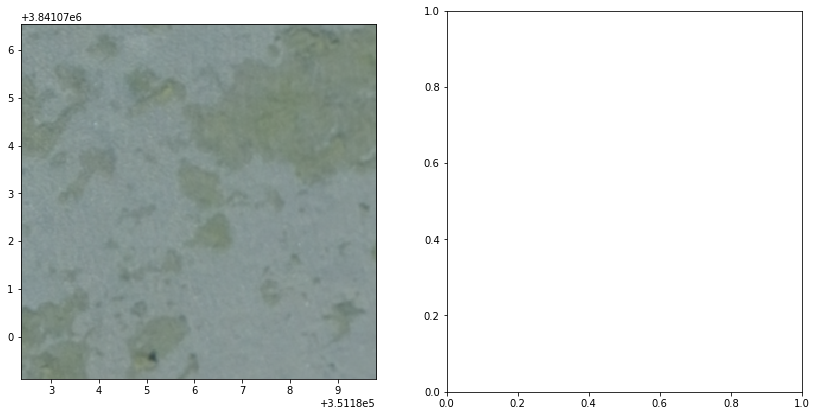

In [52]:
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
windowed_raster = dataset.read((1,2,3), window=Window(random.randint(1,100000), random.randint(1,60000), 300, 300))
show(windowed_raster, transform=dataset.transform, ax=axrgb)
#show_hist(windowed_raster, bins=25, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

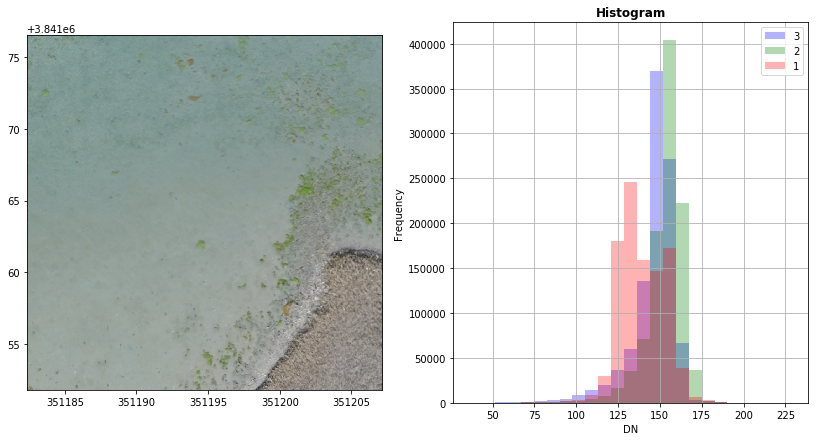

In [45]:
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
windowed_raster = dataset.read((1,2,3), window=Window(79000, 29000, 1000, 1000))
show(windowed_raster, transform=dataset.transform, ax=axrgb)
show_hist(windowed_raster, bins=25, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

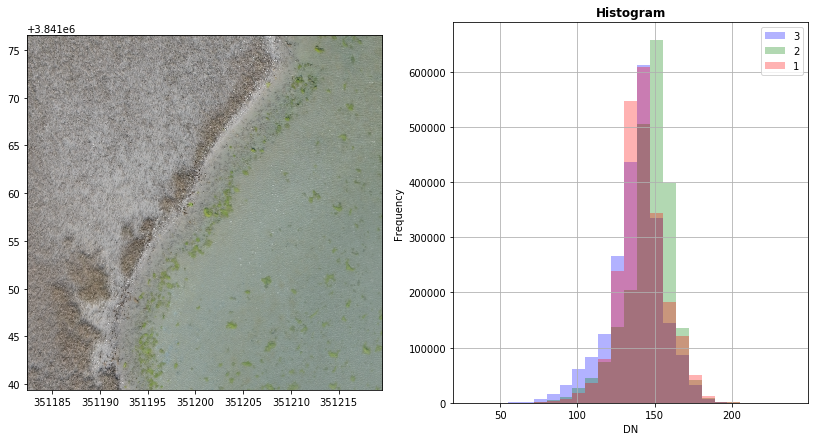

In [11]:
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
windowed_raster = dataset.read((1,2,3), window=Window(80000, 30000, 1500, 1500))
show(windowed_raster, transform=dataset.transform, ax=axrgb)
show_hist(windowed_raster, bins=25, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

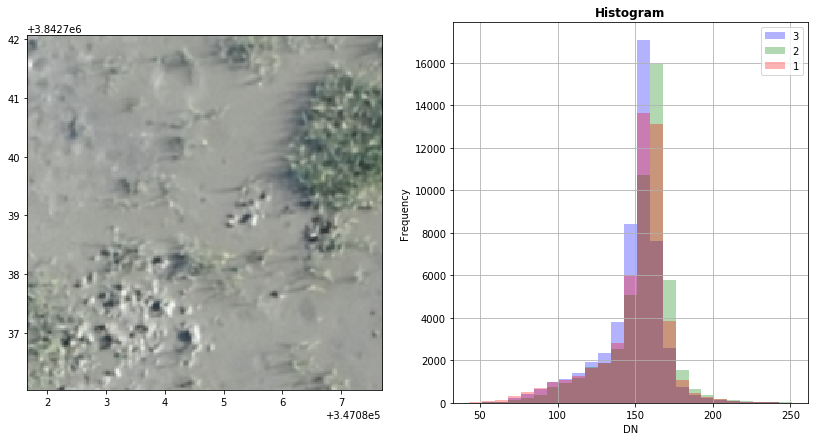

In [121]:
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
windowed_raster = dataset.read((1,2,3), window=Window(82050, 30050, 224, 224))
show(windowed_raster, transform=dataset.transform, ax=axrgb)
show_hist(windowed_raster, bins=25, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

## Visualize dataset spatially

In [84]:
dataset.crs

CRS({'init': 'epsg:32618'})

In [85]:
# Project all longitudes, latitudes
utm_tl = dataset.transform * (0, 0)
utm_br = dataset.transform * (dataset.width, dataset.height)
utm_center = dataset.transform * (dataset.width // 2, dataset.height // 2)

positions = dataset.transform * (0, 0), dataset.transform * (dataset.width, 0), dataset.transform * (dataset.width, dataset.height), dataset.transform * (0, dataset.height),

#longs, lats = transform(p1, p2, np.array(positions)[:,0],np.array(positions)[:,1])

p1 = Proj(dataset.crs)
p2 = Proj(proj='latlong',datum='WGS84')
tl_long, tl_lat = transform(p1, p2, utm_tl[0], utm_tl[1])
br_long, br_lat = transform(p1, p2, utm_br[0], utm_br[1])
center_long, center_lat = transform(p1, p2, utm_center[0], utm_center[1])
longs, lats = transform(p1, p2, np.array(positions)[:,0],np.array(positions)[:,1])

points = list(zip(lats, longs))

In [86]:
m = folium.Map(location=[center_lat, center_long])

tooltip="Raster"
folium.Polygon(points, 
               tooltip=tooltip, 
               popup='Raster Bounds',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc').add_to(m)

m

### split the image up into `height` x `width` patches

## Shapefile Handling

In [8]:
import shapely
from shapely import geometry
from shapely.geometry import shape
import fiona
import geopandas as gpd

In [9]:
oyster_shapefile = gpd.read_file(data_dir + "/shapefiles/all_merge.shp")

In [10]:
oyster_shapefile.head(5)

,Dissolve,POLY_AREA,geometry
0,1,676.689517,"POLYGON ((346760.8400834979 3842381.869193126,..."
1,1,32.140297,"POLYGON ((346862.1879106674 3842489.776664572,..."
2,1,72.681347,"POLYGON ((346791.2305920019 3842466.264884559,..."
3,1,102.479718,"POLYGON ((346802.347086563 3842484.703884688, ..."
4,1,393.125617,"POLYGON ((346848.4004151937 3842510.123082672,..."


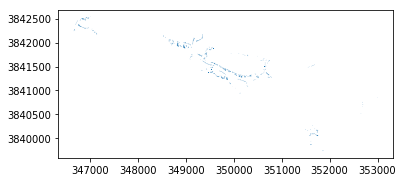

In [11]:
oyster_shapefile.plot()

In [11]:
oysters_dissolved = oyster_shapefile.dissolve(by='Dissolve')

In [16]:
oysters_dissolved.head()

,geometry,POLY_AREA
Dissolve,,
1,(POLYGON ((351864.0586236431 3839754.255073272...,676.689517


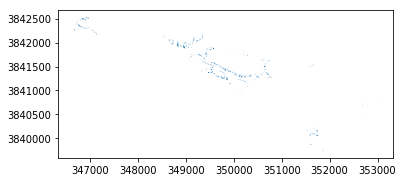

In [12]:
oysters_dissolved.plot()

In [11]:
def count_positive_tiles(dataset, tile_height, tile_width, stride, gpd_shpfile):
    pos_tile_count = 0
    blank_tile_count = 0
    img_height, img_width = dataset.shape
    
    for r in range(0, img_height-tile_height+1, stride):
        for c in range(0, img_width-tile_width+1, stride):
            tile = dataset.read((1), window=Window(c, r, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                blank_tile_count += 1
            else:
                
                # create bounds for the raster for intersection test
                points_list = []
                points_list.append(dataset.transform * (c, r))                        # tl
                points_list.append(dataset.transform * (c+tile_width, r))             # tr
                points_list.append(dataset.transform * (c+tile_width, r+tile_height)) # br
                points_list.append(dataset.transform * (c, r+tile_height))            # bl
                # turn that into a polygon
                raster_poly = geometry.Polygon([[p[0], p[1]] for p in points_list])
                
                for index, row in gpd_shpfile.iterrows():
                    feature_geom = row.geometry
                    # if the feature intersects this tile continue
                    if feature_geom.intersects(raster_poly):
                        pos_tile_count += 1
                        break
    return(pos_tile_count, blank_tile_count)

In [12]:
from rasterio.plot import reshape_as_image

def crop(dataset, tile_height, tile_width, stride, img_dict, prj_name, gpd_shpfile, pos_tiles, blank_tiles):
    img_height, img_width = dataset.shape
    
    c = r = 0
    tile_count = 0
    
    print(dataset.shape)
    print((img_width * img_height) / ((tile_height - overlap) * (tile_width - overlap)))
    """
    num_tiles = (img_width * img_height) / ((tile_height - overlap) * (tile_width - overlap))
    ratio_pos_neg = 3
    neg_tiles = pos_tiles * ratio_pos_neg
    proportion_neg = (pos_tiles / (num_tiles - blank_tiles)) * ratio_pos_neg
    """
    
    for r in range(0, img_height-tile_height+1, stride):
        for c in range(0, img_width-tile_width+1, stride):
            tile = dataset.read((1,2,3), window=Window(c, r, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            else:
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                # add the tile to the dict along with the top left pixel location in the larger raster
                top_pixel = [c,r]
                tile_name = prj_name + "---" + str(tile_count) + ".png"
                img_dict[tile_name] = top_pixel
                
                # create bounds for the raster for intersection test
                points_list = []
                points_list.append(dataset.transform * (c, r))                        # tl
                points_list.append(dataset.transform * (c+tile_width, r))             # tr
                points_list.append(dataset.transform * (c+tile_width, r+tile_height)) # br
                points_list.append(dataset.transform * (c, r+tile_height))            # bl
                # turn that into a polygon
                raster_poly = geometry.Polygon([[p[0], p[1]] for p in points_list])

                # create the JSON dict for the tile
                shape_dict = {tile_name : {
                                "fileref" : "",
                                "size" : reshaped_tile.size,
                                "filename" : tile_name,
                                "base64_img_data" : "",
                                "file_attributes" : {},
                                "regions" : {}
                            }
                        }
                
                # run through all features in the shapefile
                intersect = False
                feature_count = 0
                for index, row in gpd_shpfile.iterrows():
                    feature_geom = row.geometry
                    # if the feature intersects this tile continue
                    if feature_geom.intersects(raster_poly):                        
                        simple_shp = feature_geom.simplify(0.05, preserve_topology=False) # simply bc it has a ton of points
                        clipped_geom = simple_shp.intersection(raster_poly) # cut to only intersection of tile and feature
                        #print('found intersecting tile-shapefile')
                        #print(tile_name)
                        try:
                            #convert utm coords to px and py pixel coords
                            x, y = clipped_geom.exterior.coords.xy
                            py, px = dataset.index(x, y)
                            px[:] = [x - c for x in px]
                            py[:] = [x - r for x in py]

                            shape_dict[tile_name]["regions"][feature_count] = {"shape_attributes" : {"name" : "polygon",
                                                                                                    "all_points_x" : px,
                                                                                                    "all_points_y" : py
                                                                                                   },
                                                                              "region_attributes" : {"cover_type" : "oyster"}
                                                                             }
                            #print('feature being added')
                            #print(shape_dict[tile_name]["regions"][feature_count])
                            feature_count += 1
                            intersect = True
                        except AttributeError: 
                            # Accounting for 'AttributeError: 'MultiPolygon' object has no attribute 'exterior'
                            # which occurs when doing .exterior.coords.xy on a multipolygon
                            for multipart_shp in clipped_geom:
                                x, y = multipart_shp.exterior.coords.xy
                                py, px = dataset.index(x, y)
                                px[:] = [x - c for x in px]
                                py[:] = [x - r for x in py]

                                shape_dict[tile_name]["regions"][feature_count] = {"shape_attributes" : {"name" : "polygon",
                                                                                                        "all_points_x" : px,
                                                                                                        "all_points_y" : py
                                                                                                       },
                                                                                  "region_attributes" : {"cover_type" : "oyster"}
                                                                                 }
                                
                                #print('feature being added from multipart section')
                                #print(shape_dict[tile_name]["regions"][feature_count])
                                feature_count += 1
                                intersect = True
                #if the tile had training data add it to the dict
                # OR if the random number is below the proportion that should be negative samples
                # in which case go through and add a negative sample to the stack
                #if intersect or random.random() < proportion_neg:
                if intersect:
                    training_dict_list.update(shape_dict)
                    #print(shape_dict)
                    #print('appended to the training dict from image', tile_name)
                    tile_count += 1
                    yield reshaped_tile
                    
                # don't add an image or json file to the training stack if it doesn't have data in it
                else:
                    pass

In [51]:
from rasterio.plot import reshape_as_image

def crop(dataset, tile_height, tile_width, stride, img_dict, prj_name, gpd_shpfile, pos_tiles, blank_tiles):
    img_height, img_width = dataset.shape
    
    c = r = 0
    tile_count = 0
    
    print(dataset.shape)
    print((img_width * img_height) / ((tile_height - overlap) * (tile_width - overlap)))
    """
    num_tiles = (img_width * img_height) / ((tile_height - overlap) * (tile_width - overlap))
    ratio_pos_neg = 3
    neg_tiles = pos_tiles * ratio_pos_neg
    proportion_neg = (pos_tiles / (num_tiles - blank_tiles)) * ratio_pos_neg
    """
    
    for r in range(0, img_height-tile_height+1, stride):
        for c in range(0, img_width-tile_width+1, stride):
            tile = dataset.read((1,2,3), window=Window(c, r, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            else:
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                # add the tile to the dict along with the top left pixel location in the larger raster
                top_pixel = [c,r]
                tile_name = prj_name + "---" + str(tile_count) + ".png"
                img_dict[tile_name] = top_pixel
                
                # create bounds for the raster for intersection test
                points_list = []
                points_list.append(dataset.transform * (c, r))                        # tl
                points_list.append(dataset.transform * (c+tile_width, r))             # tr
                points_list.append(dataset.transform * (c+tile_width, r+tile_height)) # br
                points_list.append(dataset.transform * (c, r+tile_height))            # bl
                # turn that into a polygon
                raster_poly = geometry.Polygon([[p[0], p[1]] for p in points_list])

                # create the JSON dict for the tile
                shape_dict = {tile_name : {
                                "fileref" : "",
                                "size" : reshaped_tile.size,
                                "filename" : tile_name,
                                "base64_img_data" : "",
                                "file_attributes" : {},
                                "regions" : {}
                            }
                        }
                
                # run through all features in the shapefile
                intersect = False
                feature_count = 0
                feature_geom = gpd_shpfile.iloc[0].geometry #.geometry.exterior.coords.xy
                if feature_geom.intersects(raster_poly):
                    simple_shp = feature_geom.simplify(0.05, preserve_topology=False) # simply bc it has a ton of points
                    clipped_geom = simple_shp.intersection(raster_poly) # cut to only intersection of tile and feature
                    # this is a multipart shapefile so it has many parts that need to be iterated thru
                    for multipart_shp in clipped_geom:
                        x, y = multipart_shp.exterior.coords.xy
                        py, px = dataset.index(x, y)
                        px[:] = [x - c for x in px]
                        py[:] = [x - r for x in py]

                        shape_dict[tile_name]["regions"][feature_count] = {"shape_attributes" : {"name" : "polygon",
                                                                                                "all_points_x" : px,
                                                                                                "all_points_y" : py
                                                                                               },
                                                                          "region_attributes" : {"cover_type" : "oyster"}
                                                                         }

                        #print('feature being added from multipart section')
                        #print(shape_dict[tile_name]["regions"][feature_count])
                        feature_count += 1
                        intersect = True

                #if the tile had training data add it to the dict
                if intersect:
                    training_dict_list.update(shape_dict)
                    tile_count += 1
                    yield reshaped_tile
                    
                # don't add an image or json file to the training stack if it doesn't have data in it
                else:
                    pass

In [43]:
for multipart_shp in oysters_dissolved.simplify(0.05, preserve_topology=False).iloc[0]: #.geometry.exterior.coords.xy
    print(multipart_shp.exterior.coords.xy)
    break

(array('d', [353001.6101516303, 353002.75003163127, 353003.76601163077, 353004.1129316323, 353004.41029163013, 353005.35193163186, 353004.21205163084, 353003.34475163143, 353002.2296516312, 353000.9410916302, 352999.87555163144, 352998.88435163046, 352998.19051163184, 352997.57101163093, 352996.30723163066, 352995.61339163204, 352995.464711632, 352994.9443316319, 352994.101811631, 352993.50709163083, 352993.5814316309, 352994.399171631, 352995.3655916312, 352996.1585516307, 352996.8523916315, 352999.08259163203, 353001.6101516303]), array('d', [3840852.0747945393, 3840851.950894538, 3840851.703094539, 3840850.934914538, 3840849.745474538, 3840847.7382945376, 3840847.564834539, 3840848.556034538, 3840849.2746545393, 3840849.8693745374, 3840849.6959145386, 3840849.6959145386, 3840850.067614539, 3840850.290634539, 3840849.6215745388, 3840848.927734538, 3840847.193134539, 3840846.722314538, 3840847.5152745377, 3840848.4569145394, 3840849.373774538, 3840850.5384345376, 3840851.579194538, 38

In [22]:
# ingest the shapefile
oyster_shapefile = gpd.read_file(data_dir + "/shapefiles/all_merge.shp")

# set up image tiling parameters
tile_height = tile_width = 4000
overlap = 80
stride = tile_height - overlap
start_num=0
dataset = rasterio.open(infile)
training_dict_list = {}

In [23]:
#pos_tiles, blank_tiles = count_positive_tiles(dataset, tile_height, tile_width, stride, oyster_shapefile)
pos_tiles = blank_tiles = 0
pos_tiles, blank_tiles

(0, 0)

In [24]:
img_dict = {}
# create the dir if it doesn't already exist
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
    
print(img_dir)

# get the number of positive training samples and blank tiles in order to get 
# the ratio needed of random negative samples
#pos_tiles, blank_tiles = count_positive_tiles(dataset, tile_height, tile_width, stride, oyster_shapefile)

# break it up into crops
for k, tile in enumerate(crop(dataset, tile_height, tile_width, stride, img_dict, prj_name, oyster_shapefile, pos_tiles, blank_tiles), start_num):
    im = Image.fromarray(tile)
    image_name = prj_name + "---%s.png" % k
    path=os.path.join(img_dir, image_name)
    im.save(path)

../data/mosaics/middlemarshrtk22feb2017_transparent_mosaic_group1
(67238, 117433)
513.8457969335693


### add a .json file with all image names and geospatial metadata

In [25]:
len(training_dict_list)

16

In [26]:
full_dict = {"image_name" : infile,
            "image_locations" : img_dict,
             "crs" : str(dataset.crs)
            }

with open(img_dir + '/mm_data4000x4000.json', 'w') as fp:
    json.dump(full_dict, fp)
    
with open(img_dir + '/mm_region_data4000x4000.json', 'w') as fp:
    json.dump(training_dict_list, fp)

## Creating Patch Based Training Data

In [ ]:
look at a patch and decide if the center pixel is a shapefile
if so label that as a oyster piece, if not say it isn't oyster

OR
look at a patch, if that patch contains any oyster then say it is oyster


In [29]:
(67238*117433) / (224*224) / 2

78682.63765545281

In [160]:
from rasterio.plot import reshape_as_image

def crop(dataset, tile_height, tile_width, stride, prj_name, gpd_shpfile, img_list):
    img_height, img_width = dataset.shape
    
    c = r = 0
    tile_count = 0
    
    print(dataset.shape)
    print((img_width * img_height) / ((tile_height - overlap) * (tile_width - overlap)))
    """
    num_tiles = (img_width * img_height) / ((tile_height - overlap) * (tile_width - overlap))
    ratio_pos_neg = 3
    neg_tiles = pos_tiles * ratio_pos_neg
    proportion_neg = (pos_tiles / (num_tiles - blank_tiles)) * ratio_pos_neg
    """
    proportion_neg = 0.0035
    for r in range(0, img_height-tile_height+1, stride):
        for c in range(0, img_width-tile_width+1, stride):
            tile = dataset.read((1,2,3), window=Window(c, r, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            else:
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                # add the tile to the dict along with the top left pixel location in the larger raster
                top_pixel = [c,r]
                tile_name = prj_name + "---" + str(tile_count) + ".png"
                
                # create bounds for the raster for intersection test
                points_list = []
                points_list.append(dataset.transform * (c, r))                        # tl
                points_list.append(dataset.transform * (c+tile_width, r))             # tr
                points_list.append(dataset.transform * (c+tile_width, r+tile_height)) # br
                points_list.append(dataset.transform * (c, r+tile_height))            # bl
                # turn that into a polygon
                raster_poly = geometry.Polygon([[p[0], p[1]] for p in points_list])

                label=0
                # i want to merge this so we only do it once
                if gpd_shpfile.intersects(raster_poly)[1]:                        
                        label=1
            
                if label==1 or random.random() < proportion_neg:
                    img_list.append([tile_name, top_pixel, label])
                    tile_count += 1
                    yield reshaped_tile
                else:
                    pass
                    

In [ ]:
# ingest the shapefile
oyster_shapefile = gpd.read_file(data_dir + "/shapefiles/all_merge.shp")
oysters_dissolved = oyster_shapefile.dissolve(by='Dissolve')

In [161]:
# set up image tiling parameters
tile_height = tile_width = 224
overlap = 0
stride = tile_height - overlap
start_num=0
dataset = rasterio.open(infile)
img_list = []
img_list.append([infile, dataset.crs])

In [162]:
# create the dir if it doesn't already exist
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# break it up into crops
for k, tile in enumerate(crop(dataset, tile_height, tile_width, stride, prj_name, oysters_dissolved, img_list), start_num):
    im = Image.fromarray(tile)
    image_name = prj_name + "---%s.png" % k
    path=os.path.join(img_dir, image_name)
    im.save(path)

(67238, 117433)
157365.27531090562


In [163]:
import csv
with open(img_dir + '/img_labels.csv','w') as results:
    wr = csv.writer(results, dialect='excel')
    wr.writerows(img_list)

In [175]:
! cat ../data/mosaics/180522BirdSEO_WGS84_transparent_mosaic_group1/img_labels.csv

In [169]:
data_dir

'../data/'

In [187]:
bird_csv = data_dir + "mosaics/180522BirdSEO_WGS84_transparent_mosaic_group1/img_labels.csv"

# Carrot Island
carrot_csv = data_dir + "mosaics/180605CarrotEO_transparent_mosaic_group1/img_labels.csv"

# Carrot Island
mm_csv = data_dir + "mosaics/middlemarshrtk22feb2017_transparent_mosaic_group1/img_labels.csv"

all_labels = []

with open(bird_csv, newline='') as csvfile:
    labels_csv = csv.reader(csvfile, delimiter=',', quotechar='|')
    labels_list = list(labels_csv)
    labels_list.pop(0) # get rid of metadata 
    all_labels += labels_list
    
with open(carrot_csv, newline='') as csvfile:
    labels_csv = csv.reader(csvfile, delimiter=',', quotechar='|')
    labels_list = list(labels_csv)
    labels_list.pop(0) # get rid of metadata 
    all_labels += labels_list
    
with open(mm_csv, newline='') as csvfile:
    labels_csv = csv.reader(csvfile, delimiter=',', quotechar='|')
    labels_list = list(labels_csv)
    labels_list.pop(0) # get rid of metadata 
    all_labels += labels_list
    
print(len(all_labels))

7788


In [188]:
random.shuffle(all_labels)

total_count = len(all_labels)

print(total_count)

test_index = int(total_count*.1)
val_index = int(total_count*.9*.1) + test_index

print(test_index, val_index)

test_data = all_labels[:test_index]
val_data = all_labels[test_index:val_index]
train_data = all_labels[val_index:]

print(len(test_data), len(val_data), len(train_data))

7788
778 1478
778 700 6310


In [189]:
with open('../data/patch/labels/test/img_labels.csv','w') as results:
    wr = csv.writer(results)
    wr.writerows(test_data)
    
with open('../data/patch/labels/val/img_labels.csv','w') as results:
    wr = csv.writer(results)
    wr.writerows(val_data)
    
with open('../data/patch/labels/train/img_labels.csv','w') as results:
    wr = csv.writer(results)
    wr.writerows(train_data)